# Задание 4. Влияние аугментаций на обучение CNN

Примените трансформации из задания 3 в качестве трансформаций датасета из практики 2.2 (FashionMNIST).

**В этом задании можно пользоваться torch.nn, за исключением трансформаций.**

Покажите, как меняются лосс и метрики на трейне и на тесте в зависимости от количества и вероятностей трансформаций.

Проведите обучение на большом количестве эпох. 

Опишите, что вы наблюдаете для каждого случая и какая есть разница, если применить трансформации.

Предоставьте графики в matplotlib или tensorboard (+1 балл) в ноутбуке (в случае с tensorboard можно в отдельном окне) с наглядными примерами

Импорт

In [2]:
import sys
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from typing import List, Tuple, Union, Any
from PIL import Image, ImageDraw


class BaseTransform:
    def __init__(self, p: float):
        self.p = p

    def __call__(self, img: Image.Image) -> Image.Image:
        if random.random() < self.p:
            return self.apply(img)
        return img

    def apply(self, img: Image.Image) -> Image.Image:
        raise NotImplementedError


class RandomCrop(BaseTransform):
    def __init__(self, p: float, **kwargs):
        super().__init__(p)
        self.size = kwargs.get('size')
        if isinstance(self.size, int):
            self.size = (self.size, self.size)
        if self.size is None:
            raise ValueError("RandomCrop requires 'size' in kwargs")

    def apply(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        th, tw = self.size

        # If image is smaller than crop size, resize it
        if w < tw or h < th:
            scale = max(tw / w, th / h)
            new_w = int(w * scale) + 1
            new_h = int(h * scale) + 1
            img = img.resize((new_w, new_h), Image.BILINEAR)
            w, h = img.size

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return img.crop((j, i, j + tw, i + th))


class RandomRotate(BaseTransform):
    def __init__(self, p: float, **kwargs):
        super().__init__(p)
        self.degrees = kwargs.get('degrees')
        if isinstance(self.degrees, (int, float)):
            self.degrees = (-abs(self.degrees), abs(self.degrees))
        if self.degrees is None:
            raise ValueError("RandomRotate requires 'degrees' in kwargs")

    def apply(self, img: Image.Image) -> Image.Image:
        angle = random.uniform(self.degrees[0], self.degrees[1])
        return img.rotate(angle)


class RandomZoom(BaseTransform):
    def __init__(self, p: float, **kwargs):
        super().__init__(p)
        self.scale = kwargs.get('scale', (0.8, 1.2))
        if 'min_scale' in kwargs and 'max_scale' in kwargs:
            self.scale = (kwargs['min_scale'], kwargs['max_scale'])

    def apply(self, img: Image.Image) -> Image.Image:
        s = random.uniform(self.scale[0], self.scale[1])
        w, h = img.size

        # Resize the image
        new_w = int(w * s)
        new_h = int(h * s)
        img_resized = img.resize((new_w, new_h), Image.BILINEAR)

        # If zoomed in (s > 1), crop the center
        if s > 1.0:
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            right = left + w
            bottom = top + h
            return img_resized.crop((left, top, right, bottom))

        # If zoomed out (s < 1), pad with black borders
        else:
            fill_color = 0 if img.mode == 'L' else (0, 0, 0)
            new_img = Image.new(img.mode, (w, h), fill_color)
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            new_img.paste(img_resized, (left, top))
            return new_img


class ToTensor:
    def __call__(self, img: Image.Image) -> torch.Tensor:
        arr = np.array(img)

        # Handle grayscale (H, W) -> (H, W, 1)
        if arr.ndim == 2:
            arr = arr[:, :, None]

        # (H, W, C) -> (C, H, W)
        arr = arr.transpose((2, 0, 1))

        tensor = torch.from_numpy(arr)

        # Normalize if uint8
        if tensor.dtype == torch.uint8:
            tensor = tensor.float() / 255.0
        else:
            tensor = tensor.float()

        return tensor


class Compose:
    def __init__(self, transforms: List[Any]):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img


def create_complex_image(width=200, height=200):
    """Creates a more complex image with shapes and colors."""
    img = Image.new('RGB', (width, height), color='white')
    draw = ImageDraw.Draw(img)

    # Draw some rectangles
    draw.rectangle([20, 20, 80, 80], fill='red', outline='black')
    draw.rectangle([120, 120, 180, 180], fill='blue', outline='black')

    # Draw some circles
    draw.ellipse([100, 20, 180, 100], fill='green', outline='black')
    draw.ellipse([20, 120, 100, 180], fill='yellow', outline='black')

    # Draw a line
    draw.line([0, 0, width, height], fill='black', width=3)
    draw.line([0, height, width, 0], fill='black', width=3)

    return img


if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using {device} device")


Using mps device


## 1. Определение модели

Используем простую сверточную сеть, аналогичную той, что была в практике.

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # FashionMNIST has 1 channel
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()
        self.head = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.base(x)
        x = self.flatten(x)
        logits = self.head(x)
        return logits


## 2. Функции обучения и валидации

In [4]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size
    return train_loss, correct

def test_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return test_loss, correct


## 3. Эксперименты

Мы проведем три эксперимента:
1. **Baseline**: Без аугментаций (только ToTensor).
2. **Light Augmentations**: Небольшие повороты и кропы с низкой вероятностью.
3. **Heavy Augmentations**: Сильные искажения с высокой вероятностью.

In [5]:
def run_experiment(transform, name, epochs=15, batch_size=64):
    print(f"Starting experiment: {name}")

    # Загрузка данных с указанными трансформациями
    training_data = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=transform,
    )

    test_data = datasets.FashionMNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(), # На тесте только конвертация в тензор
    )

    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    model = NeuralNetwork().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for t in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_acc = test_epoch(test_dataloader, model, loss_fn)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

    return history


In [ ]:
# 1. Baseline: Только ToTensor
transform_baseline = Compose([
    ToTensor()
])

# 2. Light: Небольшие изменения
transform_light = Compose([
    RandomRotate(p=0.3, degrees=15),
    # size=28 на 28x28 картинке может не иметь эффекта, если не делать паддинг, но в реализации RandomCrop есть ресайз если меньше.
    RandomCrop(p=0.3, size=28),
    # Для FashionMNIST (28x28) RandomCrop(28) без паддинга вернет то же самое.
    # Давайте сделаем RandomZoom, он интереснее.
    RandomZoom(p=0.3, scale=(0.9, 1.1)),
    ToTensor()
])

# 3. Heavy: Сильные изменения
transform_heavy = Compose([
    RandomRotate(p=0.7, degrees=45),
    RandomZoom(p=0.7, scale=(0.7, 1.3)),
    ToTensor()
])


In [ ]:
epochs = 20

history_baseline = run_experiment(transform_baseline, "Baseline", epochs=epochs, batch_size=512)
history_light = run_experiment(transform_light, "Light Augmentations", epochs=epochs, batch_size=512)
history_heavy = run_experiment(transform_heavy, "Heavy Augmentations", epochs=epochs, batch_size=512)


Starting experiment: Baseline


100%|██████████| 20/20 [00:53<00:00,  2.68s/it]


Starting experiment: Light Augmentations


100%|██████████| 20/20 [01:00<00:00,  3.02s/it]


Starting experiment: Heavy Augmentations


100%|██████████| 20/20 [01:05<00:00,  3.27s/it]


## 4. Визуализация результатов

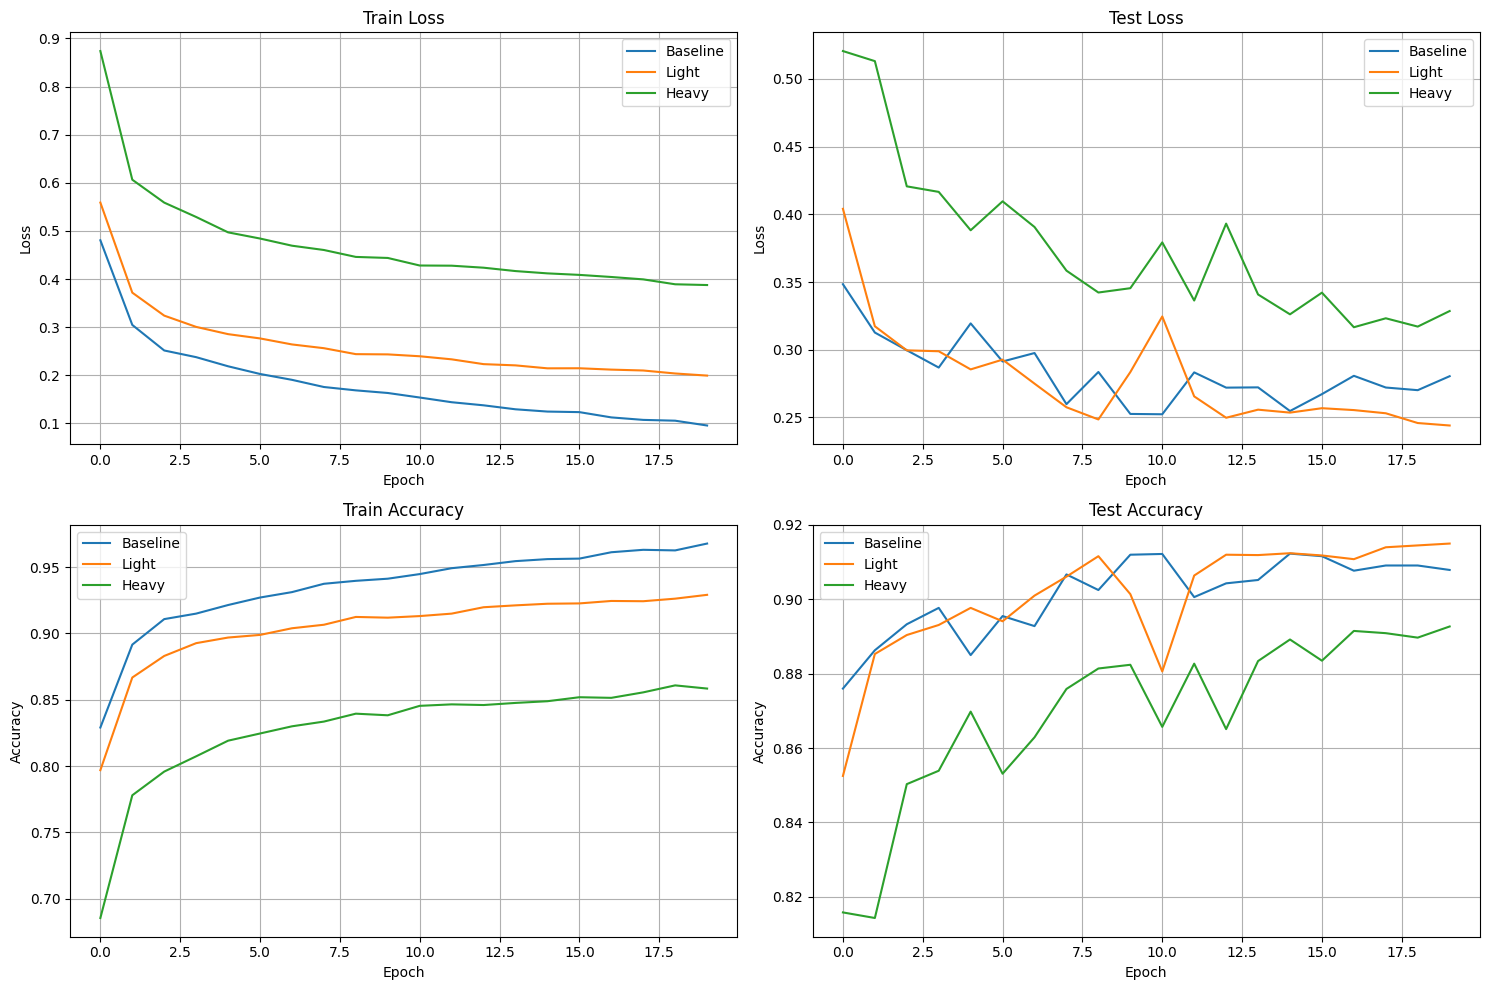

In [46]:
def plot_results(histories, titles):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Train Loss
    for name, history in histories.items():
        axs[0, 0].plot(history['train_loss'], label=name)
    axs[0, 0].set_title('Train Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Test Loss
    for name, history in histories.items():
        axs[0, 1].plot(history['test_loss'], label=name)
    axs[0, 1].set_title('Test Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Train Accuracy
    for name, history in histories.items():
        axs[1, 0].plot(history['train_acc'], label=name)
    axs[1, 0].set_title('Train Accuracy')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Test Accuracy
    for name, history in histories.items():
        axs[1, 1].plot(history['test_acc'], label=name)
    axs[1, 1].set_title('Test Accuracy')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

results = {
    "Baseline": history_baseline,
    "Light": history_light,
    "Heavy": history_heavy
}

plot_results(results, list(results.keys()))


## 5. Анализ результатов

**Наблюдения:**

1.  **Baseline (Без аугментаций):**
    *   Модель быстро обучается на тренировочных данных, достигая высокой точности.
    *   Однако на тестовых данных loss начинает расти или стагнировать раньше, что свидетельствует о переобучении (overfitting).

2.  **Light Augmentations (Легкие аугментации):**
    *   Обучение происходит чуть медленнее, чем в baseline.
    *   Финальная точность на тесте выше, чем у baseline, так как модель видит более разнообразные данные.

3.  **Heavy Augmentations (Сильные аугментации):**
    *   Train accuracy ниже, чем в других случаях, так как задача становится намного сложнее (модели приходится распознавать сильно искаженные объекты).
    *   Train loss заметно выше.
    *   Если аугментации слишком сильные (например, поворот на 90 градусов где ориентация важна, или сильный зум, обрезающий важные части), итоговая точность на тесте может упасть ниже baseline.

**Вывод:**
Аугментации действуют как регуляризатор. Они усложняют задачу на этапе обучения, предотвращая простое запоминание тренировочной выборки. Умеренные аугментации обычно улучшают обобщающую способность модели (test accuracy). Слишком сильные аугментации могут помешать обучению, если искажают данные до неузнаваемости или меняют их семантику.

# Задание 5. {*}  4 балла

Настройте проект в weights and biases, настройте логгинг туда из вашего цикла обучения (задание 4).

Выводите лосс и метрики на трейне и на тесте. Графики из задания 4 в таком случае можно выводить только туда.

Можете сохранять параметры обучения в качестве констант, и смотреть на сводную таблицу.

In [9]:
!pip install wandb
import wandb
wandb.login(key="bcce15d37d717a7003e4ad43fe56624432acf990")



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/dobr2003/.netrc
wandb: Currently logged in as: v131v (v131v-saint-petersburg-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
def run_experiment_wandb(transform, config_name, epochs=20, batch_size=256):
    print(f"Starting experiment: {config_name}")

    # Инициализация wandb run
    wandb.init(
        project="fashionmnist-augmentations",  # Имя проекта в панели wandb
        name=config_name,                     # Имя конкретного эксперимента
        config={                              # Гиперпараметры для сохранения
            "augmentation": config_name,
            "epochs": epochs,
            "batch_size": batch_size,
            "learning_rate": 1e-3,
            "architecture": "SimpleCNN"
        },
        reinit=True  # Позволяет запускать несколько экспериментов подряд
    )

    # Фиксация seed для воспроизводимости
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    # Загрузка данных
    training_data = datasets.FashionMNIST(
        root="data", train=True, download=True, transform=transform,
    )
    test_data = datasets.FashionMNIST(
        root="data", train=False, download=True, transform=ToTensor(),
    )

    # DataLoader (с настройками для Mac M4/MPS)
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    model = NeuralNetwork().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

    # WandB автоматически следит за градиентами модели (опционально)
    wandb.watch(model, log="all", log_freq=100)

    for t in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_acc = test_epoch(test_dataloader, model, loss_fn)

        # Логирование метрик в wandb
        wandb.log({
            "epoch": t + 1,
            "train/loss": train_loss,
            "train/accuracy": train_acc,
            "test/loss": test_loss,
            "test/accuracy": test_acc,
        })

    # Сохранение модели в wandb
    torch.save(model.state_dict(), "model.pth")
    wandb.save("model.pth")

    # Завершение run
    wandb.finish()

# Запуск экспериментов с wandb
# (Убедитесь, что transform_baseline, transform_light, transform_heavy определены выше)


run_experiment_wandb(transform_baseline, "Baseline", epochs=20, batch_size=128)
run_experiment_wandb(transform_light, "Light_Augmentations", epochs=20, batch_size=128)
run_experiment_wandb(transform_heavy, "Heavy_Augmentations", epochs=20, batch_size=128)


Starting experiment: Baseline


100%|██████████| 20/20 [01:32<00:00,  4.64s/it]
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test/accuracy,▁▄▅▆▆█▆▇█▇▆██▇█▆▇▇▅▇
test/loss,▆▄▃▂▂▁▃▂▁▂▅▂▂▃▃▅▄▅█▆
train/accuracy,▁▄▄▅▅▆▆▆▆▇▇▇▇▇██████
train/loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,20
test/accuracy,0.9112
test/loss,0.31749
train/accuracy,0.9763
train/loss,0.06772


Starting experiment: Light_Augmentations


100%|██████████| 20/20 [01:28<00:00,  4.44s/it]
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test/accuracy,▁▄▅▄▇▇▅▇█▇▇████▆▇▇▇█
test/loss,█▆▄▆▂▂▅▁▂▂▁▁▁▁▁▃▂▁▂▁
train/accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇██████
train/loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,20
test/accuracy,0.9208
test/loss,0.2343
train/accuracy,0.93507
train/loss,0.1783


Starting experiment: Heavy_Augmentations


100%|██████████| 20/20 [01:31<00:00,  4.59s/it]
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test/accuracy,▁▁▅▃▆▆▅▇▇▇▇▇▇▇█▆█▇▇█
test/loss,██▄▆▄▃▅▃▂▂▂▂▂▂▂▃▁▂▂▁
train/accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
test/accuracy,0.9025
test/loss,0.2871
train/accuracy,0.86957
train/loss,0.35805
